<a href="https://colab.research.google.com/github/kyu30/PokeSim/blob/main/PokeSim.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving winloss.csv to winloss (1).csv
Saving metadata_pokemon.csv to metadata_pokemon (1).csv
Saving metadata_pokemon_moves.csv to metadata_pokemon_moves (1).csv
Saving gen8randombattle.json to gen8randombattle (1).json
Saving fightpred.csv to fightpred (1).csv
Saving chart.csv to chart (1).csv


In [ ]:
import pandas as pd

In [ ]:
typechart = pd.read_csv('chart.csv', index_col = 'Attacking')

In [ ]:
winloss = pd.read_csv('winloss.csv', index_col = 'Unnamed: 0') #generated and downloaded the win-loss table created below, uploading here

In [ ]:
fightpredict = pd.read_csv('fightpred.csv', index_col = 'Unnamed: 0') #generated and downloaded the fight prediction table, uploading here

In [ ]:
moves = pd.read_csv('metadata_pokemon_moves.csv', index_col = 'Name')
moves = moves[['Accuracy', 'Power', 'Type', 'Category']]

In [ ]:
import json
def demo_read_json(filename):
    with open(filename, 'r') as myfile:
        my_dict = json.load(myfile)
    return my_dict

poke = demo_read_json('gen8randombattle.json')

#This reads a JSON file and returns the data as a Python dictionary.
#This function reads the JSON file we put in, 'gen8randombattle.json' into the 'poke' dictionary.

In [ ]:
import pandas as pd
sets = pd.DataFrame(poke)
sets = sets.T
namelist = []
for i in sets.index:
  namelist.append(i)
sets['name'] = namelist
#This is converting the 'poke' dictionary to a pandas DataFrame and then transposing it

In [ ]:
#Merging the Pokemon battle sets dataframe with the Pokemon stats
statsets = pd.read_csv('metadata_pokemon.csv', index_col = 'id')
statsets.head()
pokelist = pd.merge(sets, statsets)
pokelist = pokelist[['name', 'level', 'abilities',	'items',	'moves',	'evs',	'ivs',	'attack',	'defense',	'special_attack',	'special_defense',	'speed', 'type_1',	'type_2', 'hp']]
pokelist.index = pokelist['name']
pokelist = pokelist.drop('name', axis = 1)
pokelist = pokelist.drop(['Ditto','Zoroark'], axis = 0)

In [ ]:
from random import random
import numpy as np

# Assigning Pokemon Stats and Attributes

In [ ]:
#Picks 4 moves for a Pokemon to use
def pick(pokemon, col):
  a = list(pokelist.loc[pokemon, col].keys())
  b = list(pokelist.loc[pokemon, col].values())
  moveset =  []
  if col == 'moves':
    for i in range(len(a)-1):
      if b[i-1] == 1:
        moveset.append(a[i-1])
        a.pop(i-1)
        b.pop(i-1)
    while len(moveset) < 4:
      picked = np.random.choice(a, 1, b)[0]
      if picked not in moveset:
        moveset.append(picked)
    return moveset
print(pick("Arcanine", 'moves'))

['Flare Blitz', 'Toxic', 'Close Combat', 'Morning Sun']


In [ ]:
#Takes EVs and IVs from the dataframe and converts them from dictionaries to integers
pokelist['ivs'] = pokelist['ivs'].fillna(31)
pokelist['evs'] = pokelist['evs'].fillna(84)
pokelist['type_2'] = pokelist['type_2'].fillna('None')
def ivs(pokemon):
  return pokelist.loc[pokemon,'ivs']

def evs(pokemon):
  return pokelist.loc[pokemon,'evs']

def thisev(pokemon, stat):
  thisev = evs(pokemon)
  if evs(pokemon) != 84:
    if stat in evs(pokemon).keys():
      thisev = evs(pokemon)[stat]
    else:
      thisev = 84
  return thisev

def thisiv(pokemon, stat):
  thisiv = ivs(pokemon)
  if ivs(pokemon) != 31:
    if stat in ivs(pokemon).keys():
      thisiv = ivs(pokemon)[stat]
    else:
      thisiv = 31
  return thisiv

In [ ]:
#Calculates the actual stats of the Pokemon using base stats, IVs, EVs, and levels
def statcalc(pokemon):
  pokelist.loc[pokemon,'hp'] = int(str(((2 * pokelist.loc[pokemon,'hp'] + thisiv(pokemon, 'hp') + thisev(pokemon, 'hp')/4) * pokelist.loc[pokemon,'level'])/100 + pokelist.loc[pokemon,'level'] + 10).split('.')[0])
  pokelist.loc[pokemon,'atk'] = int(str(((2 * pokelist.loc[pokemon,'attack'] + thisiv(pokemon, 'attack') + thisev(pokemon, 'attack')/4) * pokelist.loc[pokemon,'level'])/100 + 5).split('.')[0])
  pokelist.loc[pokemon,'def'] = int(str(((2 * pokelist.loc[pokemon,'defense'] + thisiv(pokemon, 'defense') + thisev(pokemon, 'defense')/4) * pokelist.loc[pokemon,'level'])/100 + 5).split('.')[0])
  pokelist.loc[pokemon,'spa'] = int(str(((2 * pokelist.loc[pokemon,'special_attack'] + thisiv(pokemon, 'special_attack') + thisev(pokemon, 'special_attack')/4) * pokelist.loc[pokemon,'level'])/100 + 5).split('.')[0])
  pokelist.loc[pokemon,'spd'] = int(str(((2 * pokelist.loc[pokemon,'special_defense'] + thisiv(pokemon, 'special_defense') + thisev(pokemon, 'special_defense')/4) * pokelist.loc[pokemon,'level'])/100 + 5).split('.')[0])
  pokelist.loc[pokemon,'spe'] = int(str(((2 * pokelist.loc[pokemon,'speed'] + thisiv(pokemon, 'speed') + thisev(pokemon, 'speed')/4) * pokelist.loc[pokemon,'level'])/100 + 5).split('.')[0])

for index, rows in pokelist.iterrows():
  statcalc(index)

In [ ]:
pokelist = pokelist.drop(['attack',	'defense',	'special_attack',	'special_defense',	'speed'], axis = 1)

# Battle Outcome Functions and Algorithms (BOFA)

In [ ]:
#Determines which Pokemon has an advantageous type matchup
#2: Pokemon 1 has the type advantage
#1: Neither Pokemon has a type advantage against the other
#0: Pokemon 2 has the type advantage
def typematchup(poke1, poke2):
  typematch = 1
  if pokelist.loc[poke1, 'type_2'] != 'None' and pokelist.loc[poke2, 'type_2'] != 'None': #Both Pokemon have 2 types
    if typechart.loc[pokelist.loc[poke1,'type_1'], pokelist.loc[poke2, 'type_1']] * typechart.loc[pokelist.loc[poke1,'type_1'], pokelist.loc[poke2, 'type_2']] + typechart.loc[pokelist.loc[poke1,'type_2'], pokelist.loc[poke2, 'type_1']] * typechart.loc[pokelist.loc[poke1,'type_2'], pokelist.loc[poke2, 'type_1']] > typechart.loc[pokelist.loc[poke2,'type_1'], pokelist.loc[poke1, 'type_1']] * typechart.loc[pokelist.loc[poke2,'type_2'], pokelist.loc[poke1, 'type_1']] + typechart.loc[pokelist.loc[poke2,'type_1'], pokelist.loc[poke1, 'type_2']] * typechart.loc[pokelist.loc[poke2,'type_2'], pokelist.loc[poke1, 'type_2']]:
      typematch = 2
    elif typechart.loc[pokelist.loc[poke1,'type_1'], pokelist.loc[poke2, 'type_1']] * typechart.loc[pokelist.loc[poke1,'type_1'], pokelist.loc[poke2, 'type_2']] + typechart.loc[pokelist.loc[poke1,'type_2'], pokelist.loc[poke2, 'type_1']] * typechart.loc[pokelist.loc[poke1,'type_2'], pokelist.loc[poke2, 'type_1']] > typechart.loc[pokelist.loc[poke2,'type_1'], pokelist.loc[poke1, 'type_1']] * typechart.loc[pokelist.loc[poke2,'type_2'], pokelist.loc[poke1, 'type_1']] + typechart.loc[pokelist.loc[poke2,'type_1'], pokelist.loc[poke1, 'type_2']] * typechart.loc[pokelist.loc[poke2,'type_2'], pokelist.loc[poke1, 'type_2']]:
      typematch = 0
    elif typechart.loc[pokelist.loc[poke1,'type_1'], pokelist.loc[poke2, 'type_1']] * typechart.loc[pokelist.loc[poke1,'type_1'], pokelist.loc[poke2, 'type_2']] + typechart.loc[pokelist.loc[poke1,'type_2'], pokelist.loc[poke2, 'type_1']] * typechart.loc[pokelist.loc[poke1,'type_2'], pokelist.loc[poke2, 'type_1']] > typechart.loc[pokelist.loc[poke2,'type_1'], pokelist.loc[poke1, 'type_1']] * typechart.loc[pokelist.loc[poke2,'type_2'], pokelist.loc[poke1, 'type_1']] + typechart.loc[pokelist.loc[poke2,'type_1'], pokelist.loc[poke1, 'type_2']] * typechart.loc[pokelist.loc[poke2,'type_2'], pokelist.loc[poke1, 'type_2']]:
      typematch = 1
  elif pokelist.loc[poke1,'type_2'] == 'None' and pokelist.loc[poke2, 'type_2'] != 'None': #Pokemon 1 has 1 type, Pokemon 2 has 2 types
    if typechart.loc[pokelist.loc[poke1,'type_1'], pokelist.loc[poke2, 'type_1']] * typechart.loc[pokelist.loc[poke1,'type_1'], pokelist.loc[poke2, 'type_2']] > typechart.loc[pokelist.loc[poke2,'type_1'], pokelist.loc[poke1, 'type_1']] * typechart.loc[pokelist.loc[poke2,'type_2'], pokelist.loc[poke1, 'type_1']]:
      typematch = 2
    elif typechart.loc[pokelist.loc[poke1,'type_1'], pokelist.loc[poke2, 'type_1']] * typechart.loc[pokelist.loc[poke1,'type_1'], pokelist.loc[poke2, 'type_2']] < typechart.loc[pokelist.loc[poke2,'type_1'], pokelist.loc[poke1, 'type_1']] * typechart.loc[pokelist.loc[poke2,'type_2'], pokelist.loc[poke1, 'type_1']]:
      typematch = 0
    elif  typechart.loc[pokelist.loc[poke1,'type_1'], pokelist.loc[poke2, 'type_1']] * typechart.loc[pokelist.loc[poke1,'type_1'], pokelist.loc[poke2, 'type_2']] == typechart.loc[pokelist.loc[poke2,'type_1'], pokelist.loc[poke1, 'type_1']] * typechart.loc[pokelist.loc[poke2,'type_2'], pokelist.loc[poke1, 'type_1']]:
      typematch = 1
  elif pokelist.loc[poke2, 'type_2'] == 'None' and pokelist.loc[poke1, 'type_2'] != 'None': #Pokemon 1 has 2 types, Pokemon 2 has 1 type
    if typechart.loc[pokelist.loc[poke1,'type_1'], pokelist.loc[poke2, 'type_1']] * typechart.loc[pokelist.loc[poke1,'type_2'], pokelist.loc[poke2, 'type_1']] > typechart.loc[pokelist.loc[poke2,'type_1'], pokelist.loc[poke1, 'type_2']] * typechart.loc[pokelist.loc[poke2,'type_1'], pokelist.loc[poke1, 'type_1']]:
      typematch = 2
    elif typechart.loc[pokelist.loc[poke1,'type_1'], pokelist.loc[poke2, 'type_1']] * typechart.loc[pokelist.loc[poke1,'type_2'], pokelist.loc[poke2, 'type_1']] < typechart.loc[pokelist.loc[poke2,'type_1'], pokelist.loc[poke1, 'type_2']] * typechart.loc[pokelist.loc[poke2,'type_1'], pokelist.loc[poke1, 'type_1']]:
      typematch = 0
    elif  typechart.loc[pokelist.loc[poke1,'type_1'], pokelist.loc[poke2, 'type_1']] * typechart.loc[pokelist.loc[poke1,'type_2'], pokelist.loc[poke2, 'type_1']] == typechart.loc[pokelist.loc[poke2,'type_1'], pokelist.loc[poke1, 'type_2']] * typechart.loc[pokelist.loc[poke2,'type_1'], pokelist.loc[poke1, 'type_1']]:
      typematch = 1
  else: #Both Pokemon have 1 type
    if typechart.loc[pokelist.loc[poke1,'type_1'], pokelist.loc[poke2, 'type_1']] > typechart.loc[pokelist.loc[poke1,'type_1'], pokelist.loc[poke2, 'type_1']]:
      typematch = 2
    elif typechart.loc[pokelist.loc[poke1,'type_1'], pokelist.loc[poke2, 'type_1']] < typechart.loc[pokelist.loc[poke1,'type_1'], pokelist.loc[poke2, 'type_1']]:
      typematch = 0
    elif typechart.loc[pokelist.loc[poke1,'type_1'], pokelist.loc[poke2, 'type_1']] == typechart.loc[pokelist.loc[poke1,'type_1'], pokelist.loc[poke2, 'type_1']]:
      typematch = 1
  return typematch

In [ ]:
import random
#Determines which Pokemon has a better statistical matchup and by how much using each Pokemon's higher attack stat
#In the case of a tie, speed is used to break the tie, since speed determines who moves first
def statmatchup(poke1, poke2):
  d1 = 0
  d2 = 0
  a1 = 0
  a2 = 0
  if pokelist.loc[poke1,'atk'] > pokelist.loc[poke1,'spa']:
    d2 = pokelist.loc[poke2,'def']
    a1 = pokelist.loc[poke1,'atk']
  elif pokelist.loc[poke1,'atk'] < pokelist.loc[poke1,'spa']:
    d2 = pokelist.loc[poke2, 'spd']
    a1 = pokelist.loc[poke1,'spa']
  elif pokelist.loc[poke1, 'atk'] == pokelist.loc[poke1, 'spa']:
    lst = [pokelist.loc[poke2,'spd'], pokelist.loc[poke2,'def']]
    d2 = random.choice(lst)
    a1 = pokelist.loc[poke1,'atk']
  if pokelist.loc[poke2,'atk'] > pokelist.loc[poke2,'spa']:
    d1 = pokelist.loc[poke1,'def']
    a2 = pokelist.loc[poke2,'atk']
  elif pokelist.loc[poke2,'atk'] < pokelist.loc[poke2,'spa']:
    d1 = pokelist.loc[poke1, 'spd']
    a2 = pokelist.loc[poke2,'spa']
  elif pokelist.loc[poke2, 'atk'] == pokelist.loc[poke2, 'spa']:
    lst = [pokelist.loc[poke1,'spd'], pokelist.loc[poke1,'def']]
    d1 = random.choice(lst)
    a2 = pokelist.loc[poke2,'atk']
  if a1-d2 > a2-d1:
    return 2, (a1-d2) - (a2-d1)
  elif a1-d2 < a2-d1:
    return 0, (a2-d1) - (a1-d2)
  elif d2-a1 == d1-a2:
    if pokelist.loc[poke1,'spe'] > pokelist.loc[poke2, 'spe']:
      return 2, (a1-d2) - (a2-d1)
    elif pokelist.loc[poke1, 'spe'] < pokelist.loc[poke2, 'spe']:
      return 0, (a2-d1) - (a1-d2)
    else:
      return 1, 0

In [ ]:
#Determines the probability of a Pokemon winning in a fight against another using type and stat matchups
def fightpred(poke1, poke2):
  pchance1 = 50
  pchance2 = 50
  typematch = typematchup(poke1, poke2)
  statmatch, diff = statmatchup(poke1,poke2)
  if typematch == 1:
    pchance1 = pchance1
    pchance1 = pchance2
  elif typematch == 0:
    pchance2 += 25
    pchance1 -= 25
  elif typematch == 2:
    pchance1 += 25
    pchance2 -= 25
  if statmatch == 1:
    pchance1 = pchance1
    pchance2 = pchance2
  elif statmatch == 0:
    pchance2 += 15 * (1.1 + diff/150)
    pchance1 -= 15 * (1.1 + diff/150)
  elif statmatch == 2:
    pchance1 += 15 * (1.1 + diff/150)
    pchance2 -= 15 * (1.1 + diff/150)
  return float(str(pchance1)[:4])/100

In [ ]:
for index, rows in moves.iterrows():
  moves.loc[index, 'Type'] = str(moves.loc[index, 'Type'])
  moves.loc[index, 'Category'] = str(moves.loc[index, 'Category'])

In [ ]:
#Calculates the damage and range of damage of a move done to a Pokemon using the Pokemon damage formula
def damagecalc(atk, defense, move, state):
  level = pokelist.loc[atk,'level']
  a = 0
  d = 0
  if moves.loc[move,'Category'] == 'Physical':
    a = pokelist.loc[atk,'atk']
    d = pokelist.loc[defense, 'def']
  elif moves.loc[move,'Category'] == 'Special':
    a = pokelist.loc[atk,'spa']
    d = pokelist.loc[defense,'spd']
  power = moves.loc[move, 'Power']
  rand = random.randint(85,100)/100
  crit = 1
  if random.random() <= 1/24:
    crit = 1.5
  if moves.loc[move, 'Type'] == pokelist.loc[atk, 'type_1'] or pokelist.loc[atk, 'type_2']:
    stab = 1.5
  else:
    stab = 1
  if pokelist.loc[defense, 'type_2'] != 'None':
    typematch = typechart.loc[moves.loc[move,'Type'], pokelist.loc[defense, 'type_1']] * typechart.loc[moves.loc[move,'Type'], pokelist.loc[defense, 'type_2']]
  else:
    typematch = typechart.loc[moves.loc[move,'Type'], pokelist.loc[defense, 'type_1']]
  if state == 'Range':
    return f"Damage Range: {round(((((2*level)/5 + 2) * power * a/d)/50 + 2) * 1 * .85 * stab * typematch, 2)} to {round(((((2*level)/5 + 2) * power * a/d)/50 + 2) * 1 * 1 * stab * typematch, 2)}"
  elif state == 'max':
    return round(((((2*level)/5 + 2) * power * a/d)/50 + 2) * 1 * 1 * stab * typematch, 2)
  else:
    return ((((2*level)/5 + 2) * power * a/d)/50 + 2) * crit * rand * stab * typematch

In [ ]:
pokeindex = []
for index, rows in pokelist.iterrows():
  pokeindex.append(index)

In [ ]:
#Picks the best move for one Pokemon to use against another
def movepick(poke1, poke2):
  hp2 = pokelist.loc[poke2, 'hp']
  m1 = pick(poke1, 'moves')
  allattack = True
  movedamage = []
  finalmoves = []
  attacks = moves[(moves.loc[:,'Category'] == 'Physical')|(moves.loc[:,'Category'] == 'Special') ]
  for i in m1:
    if i in attacks.index:
      finalmoves.append(i)
      movedamage.append(damagecalc(poke1, poke2, i, 'max'))
  if finalmoves == []:
    return 'none'
  hdamage = movedamage[0]
  bmove = finalmoves[0]
  if len(finalmoves) == 1:
    return finalmoves[0]
  else:
    for i in range(len(finalmoves)-1):
      if movedamage[i] >= hp2:
        return finalmoves[i]
      else:
        if movedamage[i] > hdamage:
          hdamage = movedamage
          bmove = finalmoves[i]
        return bmove

In [ ]:
#Simulates a battle between two Pokemon
def battle(p1, p2):
  hp1 = pokelist.loc[p1, 'hp']
  hp2 = pokelist.loc[p2, 'hp']
#This initializes the function 'battle' with two pokémons.
  while True:
    move = movepick(p1, p2)
    move2 = movepick(p2, p1)
    if hp2 <= 0 and hp1 <=0:
      if pokelist.loc[p1, 'spe'] >= pokelist.loc[p2, 'spe']:
        return p1
      else:
        return p2
    if hp2 <= 0 or move2 == 'none':
      return p1
    if hp1 <= 0 or move == 'none':
      return p2
    if pokelist.loc[p1, 'spe'] >= pokelist.loc[p2, 'spe']:
        hp2 -= damagecalc (p1, p2, move, 'none')
        if hp2 > 0:
          hp1 -= damagecalc(p2, p1, move2, 'none')
        else:
          return p1
    elif pokelist.loc[p1, 'spe'] < pokelist.loc[p2, 'spe']:
      hp1 -= damagecalc(p2, p1, move, 'none')
      if hp1 > 0:
        hp2 -= damagecalc(p1, p2, move2, 'none')
      else:
         return p2

In [ ]:
#Assigns each Pokemon an id to easily identify during machine learning training
pid = 0
for index, rows in pokelist.iterrows():
  pid += 1
  pokelist.loc[index,'pid'] = int(str(pid))

In [ ]:
wl2 = pd.DataFrame([],[],['p1', 'p2' ,'pid'])

In [ ]:
p=0

In [ ]:
#Creates 1000 random battles to use for machine learning
for count in range(p,1000):
  i = random.choice(pokeindex)
  j = random.choice(pokeindex)
  wl2.loc[count,'p1'] = pokelist.loc[i,'pid']
  wl2.loc[count, 'p2'] = pokelist.loc[j,'pid']
  wl2.loc[count,'pid'] = pokelist.loc[battle(i,j),'pid']
  print(count)
  p += 1

972
973
974
975
976
977
978
979
980
981
982
983
984
985
986
987
988
989
990
991
992
993
994
995
996
997
998
999


In [ ]:
def avgmovepower():
  for index, row in pokelist.iterrows():
    status = moves[(moves.loc[:,'Category'] == 'Status')]
    a = list(pokelist.loc[index, 'moves'].keys())
    powersum = 0
    for i in a:
      if i in status.index:
        a.pop(a.index(i))
      else:
        if moves.loc[i, 'Type'] == pokelist.loc[index, 'type_1'] or moves.loc[i, 'Type'] == pokelist.loc[index, 'type_2']:
          powersum += moves.loc[i, 'Power'] * 1.5
        else:
          powersum += moves.loc[i, 'Power']
    powersum /= len(a)
    pokelist.loc[index,'avgpower'] = powersum

In [ ]:
avgmovepower()

In [ ]:
for index, row in wl2.iterrows():
  p1 = pokelist[pokelist.loc[:,'pid'] == wl2.loc[index, 'p1']]
  p2 = pokelist[pokelist.loc[:,'pid'] == wl2.loc[index, 'p2']]
  wl2.loc[index,'p1_type1'] = (p1.iloc[0,6])
  wl2.loc[index,'p1_type2'] = (p1.iloc[0,7])
  wl2.loc[index,'p2_type1'] = (p2.iloc[0,6])
  wl2.loc[index,'p2_type2'] = (p2.iloc[0,7])
  wl2.loc[index, 'p1_atk'] = int(p1.loc[:, 'atk'])
  wl2.loc[index, 'p1_def'] = int(p1.loc[:, 'def'])
  wl2.loc[index, 'p1_spa'] = int(p1.loc[:, 'spa'])
  wl2.loc[index, 'p1_spd'] = int(p1.loc[:, 'spd'])
  wl2.loc[index, 'p1_spe'] = int(p1.loc[:, 'spe'])
  wl2.loc[index, 'p1_hp'] = int(p1.loc[:, 'hp'])
  wl2.loc[index, 'p2_atk'] = int(p2.loc[:, 'atk'])
  wl2.loc[index, 'p2_def'] = int(p2.loc[:, 'def'])
  wl2.loc[index, 'p2_spa'] = int(p2.loc[:, 'spa'])
  wl2.loc[index, 'p2_spd'] = int(p2.loc[:, 'spd'])
  wl2.loc[index, 'p2_spe'] = int(p2.loc[:, 'spe'])
  wl2.loc[index, 'p2_hp'] = int(p2.loc[:, 'hp'])
  wl2.loc[index, 'p1_avgpower'] = int(p1.loc[:, 'avgpower'])
  wl2.loc[index, 'p2_avgpower'] = int(p1.loc[:, 'avgpower'])

In [ ]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
wl2['p1_type1'] = label_encoder.fit_transform(wl2['p1_type1'])
wl2['p2_type1'] = label_encoder.fit_transform(wl2['p2_type1'])
wl2['p1_type2'] = label_encoder.fit_transform(wl2['p1_type2'])
wl2['p2_type2'] = label_encoder.fit_transform(wl2['p2_type2'])

In [ ]:
pokelist['t1'] = label_encoder.fit_transform(pokelist['type_1'])
pokelist['t2'] = label_encoder.fit_transform(pokelist['type_2'])

In [ ]:
from collections import Counter
def battle100(poke1, poke2, num_battles=25):
    winlist = [battle(poke1, poke2) for _ in range(num_battles)]
    battle_counts = Counter(winlist)
    record1 = battle_counts[poke1]
    record2 = battle_counts[poke2]
    winloss.loc[poke1, poke2] = record1 / num_battles
    winloss.loc[poke2, poke1] = record2 / num_battles

In [ ]:
avgwin = []
avgpred = []
for i in pokeindex:
  count = 0
  count2 = 0
  for j in pokeindex:
    count += float(winloss.loc[i,j])
    count2 += float(fightpredict.loc[i,j])
  count /= len(pokeindex)
  count2 /= len(pokeindex)
  count = round((count*100))
  count2 = round(count2 *100)
  avgwin.append((i, count))
  avgpred.append((i, count2))

In [ ]:
pokewin = {}
pokepred = {}
for name, winrate in avgwin:
  pokewin[name] = winrate
for name, winrate in avgpred:
  pokepred[name] = winrate
for index, rows in pokelist.iterrows():
  pokelist.loc[index, 'avgwin'] = pokewin[index]
  pokelist.loc[index, 'avgpred'] = pokepred[index]

In [ ]:
for i in pokeindex:
  newlist = [pokelist.loc[i,'atk'], pokelist.loc[i,'def'], pokelist.loc[i,'spa'], pokelist.loc[i,'spd'], pokelist.loc[i,'spe']]
  #highstat = newlist.index(max(newlist)) +1 #Which of 5 stats is highest
  highest = (max(newlist)) #The value of the highest stat
  bst = sum(newlist) #The total of a Pokemon's stats
  #pokelist.loc[i,'highstat'] = highstat
  pokelist.loc[i,'bst'] = bst
  pokelist.loc[i, 'highest'] = highest

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
x = pokelist[['bst']]
y = pokelist['avgwin']
z = pokelist['t1']

In [ ]:
for index, rows in pokelist.iterrows():
  pokelist.loc[index, 'higher_atk'] = max(pokelist.loc[index, 'atk'], pokelist.loc[index, 'spa'])
  pokelist.loc[index, 'higher_def'] = max(pokelist.loc[index, 'def'], pokelist.loc[index, 'spd'])

In [ ]:
atk = pokelist[['higher_atk']]
defs = pokelist[['higher_def']]
speed = pokelist[['spe']]
hp = pokelist[['hp']]
bst = pokelist[['bst']]

In [ ]:
import sklearn.linear_model as lm
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
linear_model = DecisionTreeRegressor()
lin_model2 = DecisionTreeRegressor(max_depth = 3)
lm = DecisionTreeRegressor()
lm2 = DecisionTreeRegressor()
lm_speed = DecisionTreeRegressor()
lm_hp = DecisionTreeRegressor()
lm_bst = DecisionTreeRegressor
lin_model2.fit(x,y)
linear_model.fit(x, y)
lm.fit(defs, y)
lm2.fit(atk, y)
lm_speed.fit(speed,y)
lm_hp.fit(hp,y)

DecisionTreeRegressor()

0.5992734051607942

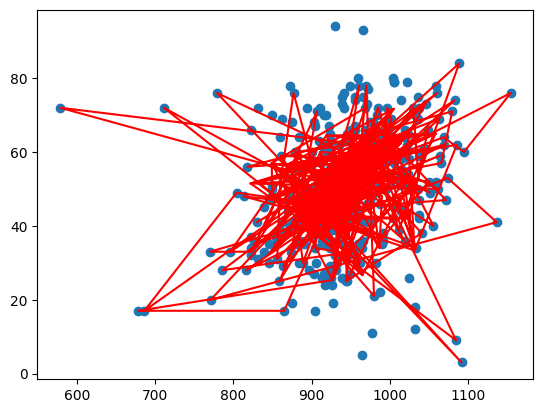

In [ ]:
#Stat Total and Win Rate
y_hat = linear_model.predict(x)
plt.plot(x,y,'o')
plt.plot(x,y_hat,'r')
linear_model.score(x,y)

0.12183381432910068

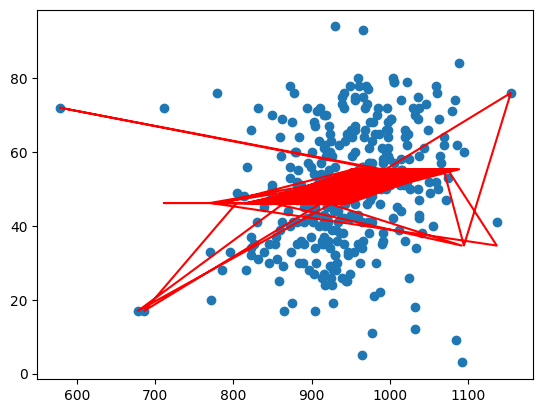

In [ ]:
hat2 = lin_model2.predict(x)
plt.plot(x,y,'o')
plt.plot(x,hat2,'r')
lin_model2.score(x,y)

In [ ]:
y2 = lm.predict(defs)
y3 = lm2.predict(atk)
y4 = lm_speed.predict(speed)
y5 = lm_hp.predict(hp)

0.5077180032821715

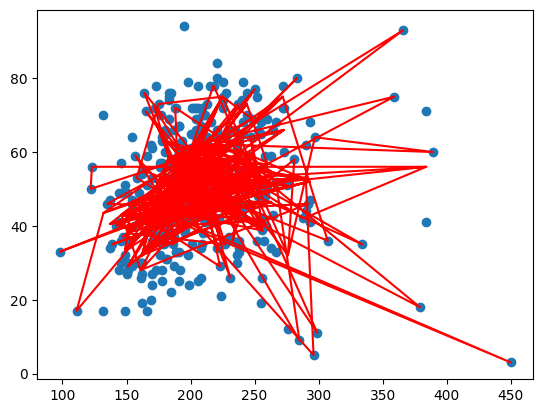

In [ ]:
#Highest Defensive Stat and Win Rate
plt.plot(defs, y, 'o')
plt.plot(defs, y2,'r')
lm.score(defs,y)

0.35413438054722257

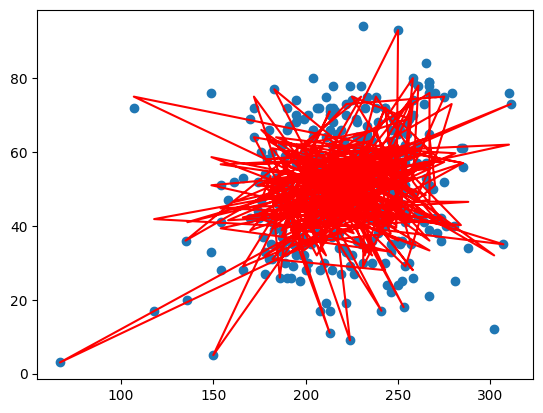

In [ ]:
#Highest Attack Stat and Win Rate
plt.plot(atk, y, 'o')
plt.plot(atk, y2,'r')
lm2.score(atk, y)

0.45980968791703614

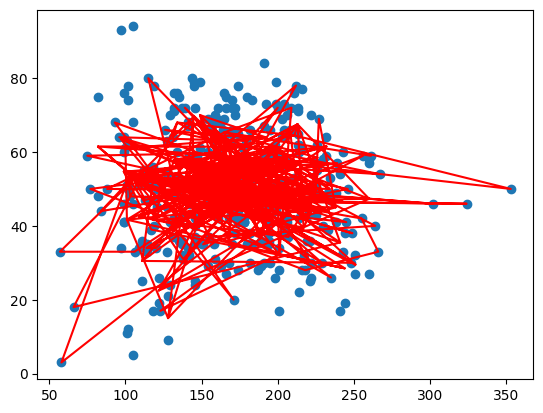

In [ ]:
#Speed and Win Rate
plt.plot(speed, y, 'o')
plt.plot(speed, y4, 'r')
lm_speed.score(speed,y)

0.4139091677882396

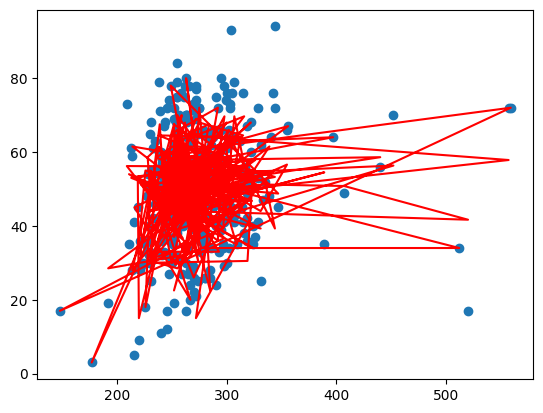

In [ ]:
#HP and Win Rate
plt.plot(hp, y, 'o')
plt.plot(hp, y4, 'r')
lm_hp.score(hp,y)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

In [ ]:
for index, rows in wl2.iterrows():
  wl2.loc[index, 'p1_bst'] = wl2.loc[index, 'p1_atk'] + wl2.loc[index, 'p1_def'] + wl2.loc[index, 'p1_spa'] + wl2.loc[index, 'p1_spd'] + wl2.loc[index, 'p1_spe']
  wl2.loc[index, 'p2_bst'] = wl2.loc[index, 'p2_atk'] + wl2.loc[index, 'p2_def'] + wl2.loc[index, 'p2_spa'] + wl2.loc[index, 'p2_spd'] + wl2.loc[index, 'p2_spe']

In [ ]:
wl2['p1'] = wl2['p1'].astype(int)
wl2['p2'] = wl2['p2'].astype(int)
wl2['pid'] = wl2['pid'].astype(int)

In [ ]:
xs = wl2[['p1', 'p2', 'p1_type1', 'p1_type2', 'p2_type1', 'p2_type2',
       'p1_atk', 'p1_def', 'p1_spa', 'p1_spd', 'p1_spe', 'p1_hp', 'p2_atk',
       'p2_def', 'p2_spa', 'p2_spd', 'p2_spe', 'p2_hp', 'p1_bst', 'p2_bst', 'p1_avgpower', 'p2_avgpower']]
winner = wl2['pid']

In [ ]:
scorelist = []
for i in range(100):
  features_train, features_test, labels_train, labels_test = train_test_split(xs, winner, test_size=0.15)
  pokeforest = RandomForestClassifier(n_estimators=200 + i * 6, max_depth = 35, min_samples_split=3, random_state = 42)
  pokeforest.fit(features_train, labels_train)
  pokeforest.score(features_test, labels_test)
  scorelist.append(pokeforest.score(features_test, labels_test))
  print(i, scorelist[i])
max(scorelist)

0 0.3333333333333333
1 0.41333333333333333
2 0.3466666666666667
3 0.37333333333333335
4 0.4
5 0.36
6 0.32666666666666666
7 0.4
8 0.36
9 0.38666666666666666
10 0.36
11 0.3
12 0.42
13 0.4066666666666667
14 0.36
15 0.38666666666666666
16 0.4
17 0.44666666666666666
18 0.38
19 0.41333333333333333
20 0.43333333333333335
21 0.38
22 0.38
23 0.36666666666666664
24 0.38666666666666666
25 0.3933333333333333
26 0.4266666666666667
27 0.3466666666666667
28 0.38
29 0.3466666666666667
30 0.37333333333333335
31 0.3466666666666667
32 0.38666666666666666
33 0.4
34 0.38666666666666666
35 0.36666666666666664
36 0.3933333333333333
37 0.38
38 0.31333333333333335
39 0.3333333333333333
40 0.38666666666666666
41 0.35333333333333333
42 0.38
43 0.37333333333333335
44 0.36
45 0.38
46 0.44666666666666666
47 0.47333333333333333
48 0.38666666666666666
49 0.4


0.47333333333333333

In [ ]:
scorelist = []
for i in range(100):
  features_train, features_test, labels_train, labels_test = train_test_split(xs, winner, test_size=0.15)
  pokeforest = RandomForestClassifier(n_estimators=500, max_depth = 5, min_samples_split=3, random_state = 42)
  pokeforest.fit(features_train, labels_train)
  pokeforest.score(features_test, labels_test)
  scorelist.append(pokeforest.score(features_test, labels_test))
  print(i, scorelist[i])
max(scorelist)

0 0.20666666666666667
1 0.22
2 0.22666666666666666
3 0.16666666666666666
4 0.22666666666666666
5 0.25333333333333335
6 0.15333333333333332
7 0.2733333333333333
8 0.22
9 0.22
10 0.17333333333333334
11 0.23333333333333334
12 0.24
13 0.16
14 0.16
15 0.20666666666666667
16 0.19333333333333333
17 0.24
18 0.25333333333333335
19 0.2
20 0.22666666666666666
21 0.18666666666666668
22 0.24
23 0.26666666666666666
24 0.24
25 0.21333333333333335
26 0.29333333333333333
27 0.2
28 0.28
29 0.18666666666666668
30 0.22
31 0.24
32 0.22666666666666666
33 0.24666666666666667
34 0.24666666666666667
35 0.22666666666666666
36 0.18666666666666668
37 0.29333333333333333
38 0.24666666666666667
39 0.20666666666666667
40 0.19333333333333333
41 0.22
42 0.20666666666666667
43 0.20666666666666667
44 0.19333333333333333
45 0.23333333333333334
46 0.20666666666666667
47 0.26
48 0.28
49 0.2


0.29333333333333333

In [ ]:
pokeforest.feature_importances_

array([0.05239204, 0.04875763, 0.0357384 , 0.03566853, 0.03424831,
       0.03449283, 0.04514821, 0.04263908, 0.04764508, 0.05254802,
       0.0508847 , 0.04825276, 0.05159128, 0.04429576, 0.04790109,
       0.05215445, 0.0484306 , 0.047637  , 0.0484056 , 0.04994785,
       0.04112315, 0.04009763])

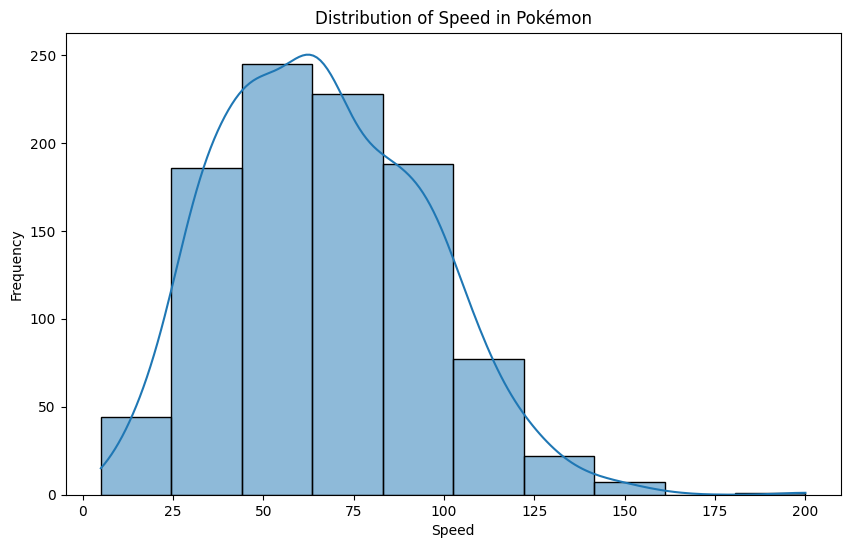

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
sns.histplot(statsets['speed'], kde=True, bins=10)
plt.title('Distribution of Speed in Pokémon')
plt.xlabel('Speed')
plt.ylabel('Frequency')
plt.show()

In [ ]:
import numpy as np
from scipy import stats
x = pokelist['avgwin']
y = pokelist['avgpower']
correff = stats.pearsonr(x, y)
correff

PearsonRResult(statistic=0.02801886821211219, pvalue=0.604540065725058)

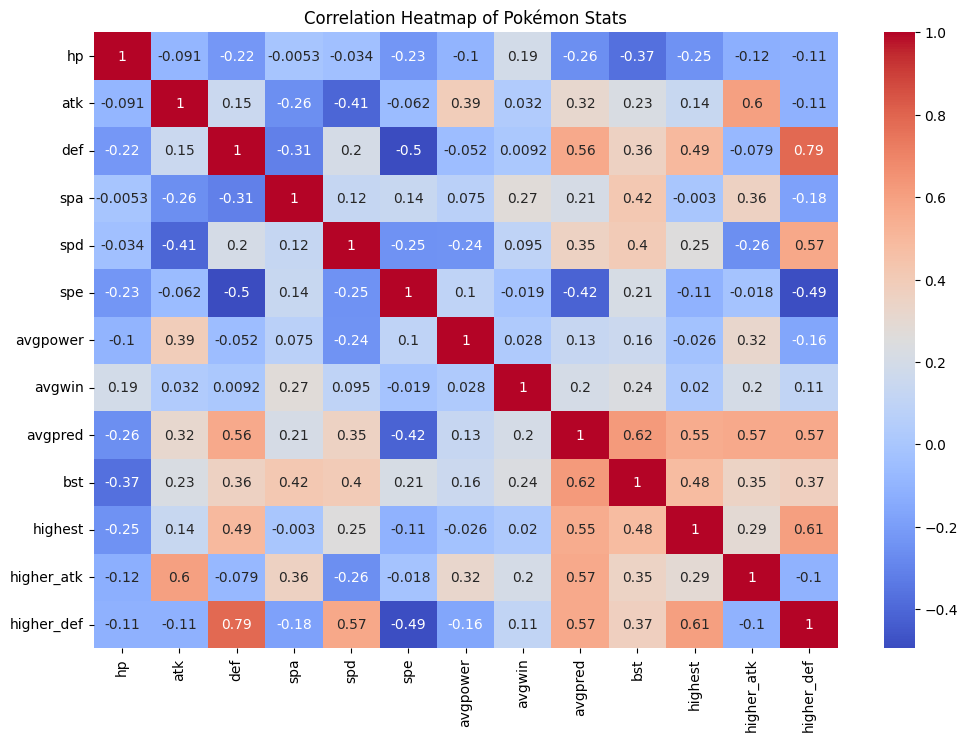

In [ ]:
plt.figure(figsize=(12, 8))
corr = pokelist[['hp', 'atk', 'def', 'spa', 'spd', 'spe', 'avgpower',
        'avgwin', 'avgpred', 'bst', 'highest', 'higher_atk',
       'higher_def']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap of Pokémon Stats')
plt.show()

In [ ]:
sns.pairplot(statsets[['hp', 'attack', 'defense', 'special_attack', 'special_defense', 'speed', 'height', 'weight']])

In [ ]:
for index, rows in pokelist.iterrows():
  if pokelist.loc[index, 'type_2'] == 'None':
    pokelist.loc[index, 'both_types'] = str(pokelist.loc[index, 'type_1'])
  else:
    pokelist.loc[index, 'both_types'] = str(pokelist.loc[index, 'type_1']) + '/' + str(pokelist.loc[index, 'type_2'])

In [ ]:
tcounts = pokelist['both_types'].value_counts()

In [ ]:
typecombos = pokelist['both_types'].tolist()
for index, rows in pokelist.iterrows():
  if (tcounts[pokelist.loc[index, 'both_types']] < 3):
    pokelist.loc[index, 'both_types'] = pokelist.loc[index, 'type_1']

In [ ]:
type_counts = pokelist['both_types']
win_rates = pokelist['avgwin']
fig, ax = plt.subplots(figsize=(15,15))
sns.boxplot(data=pokelist, x = win_rates, y = type_counts, ax = ax)

In [ ]:
import scipy
from scipy.stats import chi2_contingency

#data = [pokelist['higher_atk'], pokelist['spe']]
#avgpred is a prediction, avgwin is the actual win rate
_, p = scipy.stats.ttest_ind(pokelist['avgpred'], pokelist['avgwin'])
p

0.0018579677154881818